# Bayesian Linear Regression Comparison

This notebook compares two approaches to Bayesian Linear Regression:
1.  **Conjugate Prior (Exact Inference)**: Using a Normal-Inverse-Gamma joint prior.
2.  **Independent Priors (Approximate Inference)**: Using independent Normal and Inverse-Gamma priors, solved via Mean-Field Variational Inference (VI).

We will demonstrate that while the VI approach is more flexible (allowing independent priors), it tends to underestimate the posterior variance compared to the exact method.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Synthetic Data Generation

We generate data from a linear model:
$$ y = Xw + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2) $$

where $w = [2.0, -3.0]^T$ (slope, intercept) and $\sigma^2 = 1.5$.

Data shape: X (50, 2), y (50,)


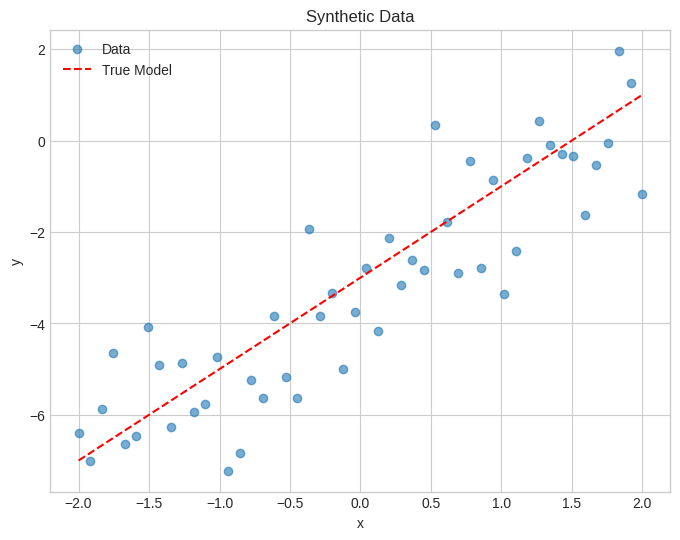

In [3]:
# True parameters
true_w = np.array([2.0, -3.0]) # [slope, intercept]
true_sigma2 = 1.5
N = 50

# Generate X (feature + bias term)
X_raw = np.linspace(-2, 2, N)
X = np.vstack([X_raw, np.ones(N)]).T

# Generate y
epsilon = np.sqrt(true_sigma2) * np.random.randn(N)
y = X @ true_w + epsilon

print(f"Data shape: X {X.shape}, y {y.shape}")

plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], y, label='Data', alpha=0.6)
plt.plot(X[:,0], X @ true_w, 'r--', label='True Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Synthetic Data')
plt.show()

## 2. Method 1: Conjugate Joint Prior (Exact)

**Model:**
- Likelihood: $y \sim \mathcal{N}(Xw, \sigma^2 I)$
- Prior (Normal-Inverse-Gamma): 
  - $\sigma^2 \sim IG(a_0, b_0)$
  - $w | \sigma^2 \sim \mathcal{N}(\mu_0, \sigma^2 \Lambda_0^{-1})$

**Posterior** ($p(w, \sigma^2 | y)$) is also Normal-Inverse-Gamma with parameters:
- $\Lambda_N = X^T X + \Lambda_0$
- $\mu_N = \Lambda_N^{-1} (\Lambda_0 \mu_0 + X^T y)$
- $a_N = a_0 + N/2$
- $b_N = b_0 + \frac{1}{2} (y^T y + \mu_0^T \Lambda_0 \mu_0 - \mu_N^T \Lambda_N \mu_N)$

In [4]:
# Hyperparameters
mu_0 = np.zeros(2)
Lambda_0 = np.eye(2) # Precision matrix part
a_0 = 2.0
b_0 = 1.0

# --- Update Rules ---
Lambda_N = X.T @ X + Lambda_0
Lambda_N_inv = np.linalg.inv(Lambda_N)
mu_N = Lambda_N_inv @ (Lambda_0 @ mu_0 + X.T @ y)
a_N = a_0 + N / 2
b_N = b_0 + 0.5 * (y.T @ y + mu_0.T @ Lambda_0 @ mu_0 - mu_N.T @ Lambda_N @ mu_N)

print("--- Method 1 Results ---")
print(f"Posterior Mean w: {mu_N}")
print(f"Posterior Mean sigma^2: {b_N / (a_N - 1):.4f}")

--- Method 1 Results ---
Posterior Mean w: [ 1.79657106 -3.21190981]
Posterior Mean sigma^2: 1.4939


## 3. Method 2: Independent Priors (Variational Inference)

**Model:**
- Likelihood: $y \sim \mathcal{N}(Xw, \sigma^2 I)$
- Priors (Independent):
  - $w \sim \mathcal{N}(\mu_0, \Sigma_0)$ (Note: $\Sigma_0$ is fixed, not scaled by $\sigma^2$)
  - $\sigma^2 \sim IG(a_0, b_0)$

Since the true posterior $p(w, \sigma^2 | y)$ does not factorize, we approximate it with $q(w, \sigma^2) = q(w)q(\sigma^2)$ using Mean-Field VI.

**Update Equations (Coordinate Ascent):**
1. $q(w) = \mathcal{N}(\mu_w, \Sigma_w)$
   - $\Sigma_w = (\mathbb{E}_{q(\sigma^2)}[1/\sigma^2] X^T X + \Sigma_0^{-1})^{-1}$
   - $\mu_w = \Sigma_w (\mathbb{E}_{q(\sigma^2)}[1/\sigma^2] X^T y + \Sigma_0^{-1} \mu_0)$
2. $q(\sigma^2) = IG(a_q, b_q)$
   - $a_q = a_0 + N/2$
   - $b_q = b_0 + \frac{1}{2} \mathbb{E}_{q(w)}[||y - Xw||^2]$

In [5]:
# Prior Hyperparameters (Independent Structure)
mu_0_vi = np.zeros(2)
sig = 1.0
Sigma_0_vi = np.eye(2) * sig
inv_Sigma_0_vi = np.eye(2) / sig
a_0_vi = 2.0
b_0_vi = 1.0

# Initialize Variational Parameters
mu_w_vi = np.zeros(2)
Sigma_w_vi = np.eye(2)
a_q = a_0_vi + N / 2
b_q = b_0_vi # Initial guess
E_inv_sigma2 = a_q / b_q

history_mw = []
max_iter = 30

print("Starting VI iterations...")
for i in range(max_iter):
    # --- Update q(w) ---
    Sigma_w_vi = np.linalg.inv(E_inv_sigma2 * (X.T @ X) + inv_Sigma_0_vi)
    mu_w_vi = Sigma_w_vi @ (E_inv_sigma2 * (X.T @ y) + inv_Sigma_0_vi @ mu_0_vi)
    
    # --- Update q(sigma^2) ---
    # E[||y - Xw||^2] = ||y - X mu_w||^2 + Tr(X^T X Sigma_w)
    sse = np.sum((y - X @ mu_w_vi)**2)
    trace_term = np.trace(X.T @ X @ Sigma_w_vi)
    b_q = b_0_vi + 0.5 * (sse + trace_term)
    
    # Update Expectation used in next q(w) step
    E_inv_sigma2 = a_q / b_q
    
    history_mw.append(mu_w_vi.copy())

print("--- Method 2 Results (VI) ---")
print(f"Posterior Mean w: {mu_w_vi}")
print(f"Posterior Mean sigma^2: {b_q / (a_q - 1):.4f}")

Starting VI iterations...
--- Method 2 Results (VI) ---
Posterior Mean w: [ 1.7905946  -3.19718189]
Posterior Mean sigma^2: 1.2824


## 4. Comparison and Visualization

We will compare:
1. **Predictive Uncertainty**: Visualizing the 95% confidence intervals for $y$.
2. **Factorized vs Joint Posterior**: How `q(w)q(sigma^2)` differs from `p(w, sigma^2)`.

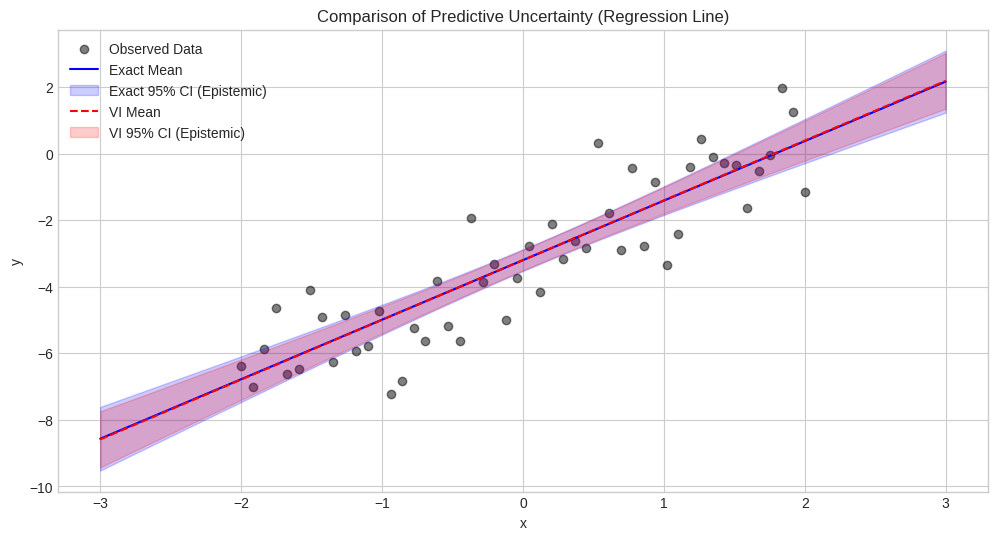

In [6]:
def get_predictive_samples_exact(mu_n, Lambda_n_inv, a_n, b_n, X_new, n_samples=1000):
    # 1. Sample sigma^2 from IG(a_n, b_n)
    sigma2_samples = stats.invgamma.rvs(a_n, scale=b_n, size=n_samples)
    
    preds = []
    for s2 in sigma2_samples:
        # 2. Sample w from N(mu_n, sigma^2 * Lambda_n^-1)
        w_s = np.random.multivariate_normal(mu_n, s2 * Lambda_n_inv)
        # 3. Predict y without noise (for mean conf interval) or with noise (for pred interval)
        # Here we plot the interval of the REGRESSION LINE (epistemic uncertainty)
        preds.append(X_new @ w_s)
    return np.array(preds)

def get_predictive_samples_vi(mu_w, Sigma_w, a_q, b_q, X_new, n_samples=1000):
    # 1. Sample sigma^2 from IG(a_q, b_q)
    sigma2_samples = stats.invgamma.rvs(a_q, scale=b_q, size=n_samples)
    # 2. Sample w from N(mu_w, Sigma_w) INDEPENDENTLY of sigma^2
    w_samples = np.random.multivariate_normal(mu_w, Sigma_w, size=n_samples)
    
    preds = []
    for w_s in w_samples:
        preds.append(X_new @ w_s)
    return np.array(preds)

# Setup Grid
X_grid_raw = np.linspace(-3, 3, 100)
X_grid = np.vstack([X_grid_raw, np.ones(100)]).T

# Draw samples
preds_exact = get_predictive_samples_exact(mu_N, Lambda_N_inv, a_N, b_N, X_grid)
preds_vi = get_predictive_samples_vi(mu_w_vi, Sigma_w_vi, a_q, b_q, X_grid)

# Compute Statistics
mean_exact = preds_exact.mean(axis=0)
std_exact = preds_exact.std(axis=0)
mean_vi = preds_vi.mean(axis=0)
std_vi = preds_vi.std(axis=0)

# --- Plotting ---
plt.figure(figsize=(12, 6))

# Plot Data
plt.scatter(X[:,0], y, color='black', alpha=0.5, label='Observed Data')

# Plot Exact
plt.plot(X_grid_raw, mean_exact, 'b-', label='Exact Mean')
plt.fill_between(X_grid_raw, 
                 mean_exact - 2*std_exact, 
                 mean_exact + 2*std_exact, 
                 color='blue', alpha=0.2, label='Exact 95% CI (Epistemic)')

# Plot VI
plt.plot(X_grid_raw, mean_vi, 'r--', label='VI Mean')
plt.fill_between(X_grid_raw, 
                 mean_vi - 2*std_vi, 
                 mean_vi + 2*std_vi, 
                 color='red', alpha=0.2, label='VI 95% CI (Epistemic)')

plt.title("Comparison of Predictive Uncertainty (Regression Line)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Analysis using Posterior Covariance

A key difference is in the posterior structure of $w$.

- **Exact**: $Cov(w) \propto \sigma^2 \Lambda_N^{-1}$. Since $\sigma^2$ is a random variable, the marginal distribution of $w$ is actually a Multivariate Student-t (heavier tails).
- **VI**: $Cov(w) = \Sigma_w$. This is a fixed Gaussian covariance.

In [7]:
print(f"Exact Expected Sigma^2: {b_N / (a_N - 1):.4f}")
print(f"VI Expected Sigma^2:    {b_q / (a_q - 1):.4f}")

# Compare the diagonal of the covariance/precision matrices for w
# For Exact, conditional cov is sigma^2 * Lambda_N^-1. We approximate using E[sigma^2]
exact_cov_approx = (b_N / (a_N - 1)) * Lambda_N_inv

print("\nApproximate Covariance of w (Slope, Intercept):")
print("Exact (using mean sigma^2):\n", exact_cov_approx)
print("VI (Sigma_w):\n", Sigma_w_vi)

print("\nVariance of Slope:")
print(f"Exact: {exact_cov_approx[0,0]:.4f}")
print(f"VI:    {Sigma_w_vi[0,0]:.4f}")

Exact Expected Sigma^2: 1.4939
VI Expected Sigma^2:    1.2824

Approximate Covariance of w (Slope, Intercept):
Exact (using mean sigma^2):
 [[2.12237829e-02 2.21770658e-18]
 [2.21770658e-18 2.92920477e-02]]
VI (Sigma_w):
 [[1.74863520e-02 1.81879817e-18]
 [1.81879817e-18 2.41033433e-02]]

Variance of Slope:
Exact: 0.0212
VI:    0.0175


**Conclusion:**
Depending on the data and noise level, the VI approximation often underestimates the variance because it ignores the correlation between the uncertainty in $w$ and the uncertainty in $\sigma^2$. In the exact model, if $\sigma^2$ is large, our uncertainty in $w$ grows. In the VI independent model, this coupling is broken.